In [ ]:
%pdb

In [ ]:
%run dqn_atari.py --env "SpaceInvadersNoFrameskip-v0" -o ./runs --seed 42 

# Evaluation

In [1]:
import deeprl_hw2 as tfrl
from dqn_atari import create_model
from deeprl_hw2.dqn import DQNAgent
from deeprl_hw2.preprocessors import *
from deeprl_hw2.objectives import mean_huber_loss


import torch
import gymnasium as gym
import ale_py

import matplotlib.pyplot as plt


# Hyperparameters
input_shape = (84, 84)
window = 4
gamma = 0.99
n_steps = int(1e6)
max_size = int(1e6)
batchsize = 32
target_update_frequency = int(1e4)
lr = 1e-4
warm_up = int(5e4)

gym.register_envs(ale_py)
env = tfrl.utils.AtariWrapper(gym.make("SpaceInvadersNoFrameskip-v0"))

agent = DQNAgent(
    q_network=create_model(window, env.action_space.n, model_type="linear"),
    policy=tfrl.policy.LinearDecayGreedyEpsilonPolicy(
        tfrl.policy.GreedyEpsilonPolicy, "epsilon", 1.0, 0.1, max_size
    ),
    preprocessor=AtariPreprocessor(input_shape, window=window),
    memory=tfrl.core.ReplayMemory(max_size, window, state_shape=input_shape),
    gamma=gamma,
    target_update_freq=target_update_frequency,
    train_freq=4,
    num_burn_in=warm_up,
    batch_size=batchsize,
    ddqn=False,
    use_wandb=False,
)

/home/tovitu/miniconda3/envs/drl/lib/python3.10/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment SpaceInvadersNoFrameskip-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


Using Linear model
Using DQN


In [2]:
#path = "runs/SpaceInvadersNoFrameskip-v0-linear-dqn-run1/"
path = "runs/SpaceInvadersNoFrameskip-v0-linear-ddqn-run2/"
#path = "runs/SpaceInvadersNoFrameskip-v0-cnn-dqn-run3/"
#path = "runs/SpaceInvadersNoFrameskip-v0-cnn-ddqn-run4/"
#path = "runs/SpaceInvadersNoFrameskip-v0-duel-ddqn-run4/"

agent.compile(optimizer=torch.optim.Adam, loss_func=mean_huber_loss, lr=lr)
agent.load_model(path+'dqn.pth')

Model loaded from runs/SpaceInvadersNoFrameskip-v0-linear-ddqn-run2/dqn.pth


/home/tovitu/codes/AI_projects/deeprl_hw2_src/deeprl_hw2/dqn.py:514: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.Q.load_state_dict(torch.load(ckpt_path))
/home/tovitu

In [6]:
rs = agent.evaluate(env, 100)
np.mean(rs), np.std(rs)

Average rewards: 492.8
All rewards: [465.0, 415.0, 365.0, 440.0, 395.0, 440.0, 625.0, 720.0, 690.0, 840.0, 360.0, 655.0, 360.0, 380.0, 470.0, 365.0, 480.0, 495.0, 505.0, 395.0, 200.0, 335.0, 605.0, 810.0, 325.0, 865.0, 375.0, 370.0, 700.0, 610.0, 480.0, 915.0, 445.0, 430.0, 1245.0, 315.0, 475.0, 380.0, 380.0, 335.0, 485.0, 455.0, 610.0, 380.0, 415.0, 510.0, 425.0, 500.0, 465.0, 650.0, 635.0, 415.0, 530.0, 415.0, 440.0, 610.0, 415.0, 480.0, 575.0, 245.0, 425.0, 350.0, 460.0, 465.0, 310.0, 425.0, 835.0, 530.0, 480.0, 585.0, 350.0, 790.0, 390.0, 395.0, 350.0, 410.0, 430.0, 230.0, 555.0, 355.0, 665.0, 235.0, 495.0, 630.0, 470.0, 600.0, 540.0, 595.0, 380.0, 405.0, 540.0, 465.0, 400.0, 450.0, 620.0, 470.0, 495.0, 955.0, 290.0, 350.0]


(np.float64(492.8), np.float64(166.58679419449788))

In [7]:
eval_env = gym.make("SpaceInvadersNoFrameskip-v0")
agent.render_eval_video(env, output_path=path+'eval.mp4')

/home/tovitu/miniconda3/envs/drl/lib/python3.10/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment SpaceInvadersNoFrameskip-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


Total reward: 450.0
Video saved at runs/SpaceInvadersNoFrameskip-v0-duel-ddqn-run4/eval.mp4


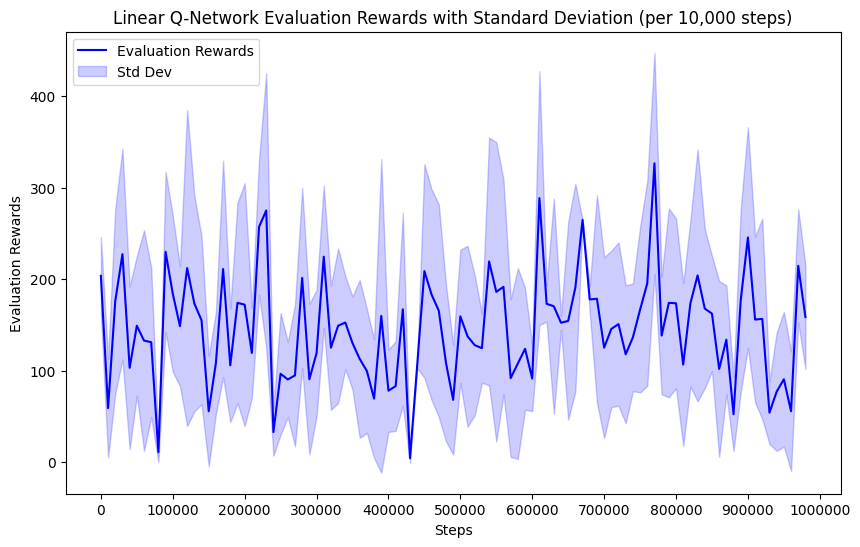

In [3]:
# Assuming eval_rewards and eval_rewards_std are loaded as numpy arrays

eval_rewards = np.load(f'{path}eval_rewards.npy')
eval_rewards_std = np.load(f'{path}eval_rewards_std.npy')

# Re-adjust the x-axis considering there are only 99 values
x_steps = np.arange(0, 1000000, 10000)[:99]  # Limit to 99 points

# Create the updated line plot with the new x-axis
plt.figure(figsize=(10, 6))
plt.plot(x_steps, eval_rewards, label='Evaluation Rewards', color='b')
plt.fill_between(x_steps, eval_rewards - eval_rewards_std, eval_rewards + eval_rewards_std, color='b', alpha=0.2, label='Std Dev')

# Update x-axis labels and plot title
plt.xlabel('Steps')
plt.ylabel('Evaluation Rewards')
plt.title('Linear Q-Network Evaluation Rewards with Standard Deviation (per 10,000 steps)')
plt.xticks(ticks=np.arange(0, 1000001, 100000), labels=np.arange(0, 1000001, 100000))
plt.legend()